In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score
import graphviz
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [5]:
df = pd.read_csv("diabetic_data.csv")

In [6]:
#remove unknown race.
df = df[df.race != "?"]
#remove unknown gender.
df = df[df.gender != "Unknown/Invalid"]
# remove "newborn" since there are only around 20 records.
df = df[df.admission_type_id != 4]

df = df[df.discharge_disposition_id != 11]
df = df[df.discharge_disposition_id != 13]
df = df[df.discharge_disposition_id != 14]
df = df[df.discharge_disposition_id != 19]
df = df[df.discharge_disposition_id != 20]
df = df[df.discharge_disposition_id != 21]

df = df.drop_duplicates('patient_nbr')

In [7]:
df.drop(['encounter_id','patient_nbr','weight','discharge_disposition_id','payer_code','diag_2', 'diag_3','max_glu_serum','metformin', 'repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton','insulin', 'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone',], axis=1, inplace=True)

In [8]:
df.shape

(68158, 19)

In [9]:
def consolidate(value):
    if value == "<30":
        return 1
    if value == ">30":
        return 0
    
    else: return 0

df['readmitted'] = df.apply(lambda row:consolidate(row['readmitted']),axis=1)
df['target'] = df['readmitted']

In [10]:
#data preprocessing function for Gender:
def dp_gender(value):
    if value == "Male":
        return 1
    else:
        return 0

df['Is_Male'] = df.apply(lambda row:dp_gender(row['gender']),axis=1)
df.drop("gender", axis=1, inplace=True)

In [11]:
#data preprocessing function for age, replaced the categorical with median
def dp_age(value):
    if value == "[0-10)":
        return 5
    elif value == "[10-20)":
        return 15
    elif value == "[20-30)":
        return 25
    elif value == "[30-40)":
        return 35
    elif value == "[40-50)":
        return 45
    elif value == "[50-60)":
        return 55
    elif value == "[60-70)":
        return 65
    elif value == "[70-80)":
        return 75
    elif value == "[80-90)":
        return 85
    else: return 95
    
df['age'] = df.apply(lambda row:dp_age(row['age']),axis=1)

In [12]:
#data preprocessing function for admission type. merged the categories
#Emergency ,Urgent and Trauma Center AND Not Available, NULL and Not Mapped as
#"Not Avail", Newborn is ignored since there are only 20 records.
def dp_adm_type(value):
    if value == 5 or value == 6 or value == 8:
        return "Not Avail"
    elif value == 1 or value == 2 or value == 7:
        return "Urgent"
    else:
        return "Elective"

df['admission_type'] = df.apply(lambda row:dp_adm_type(row['admission_type_id']),axis=1)
# drop old admission type ID.
df.drop('admission_type_id', axis=1, inplace=True)

In [13]:
#data preprocessing function for age, replaced the categorical with median
def dp_diag(val):
    try: 
        value = float(val)
    except ValueError:
        return "Other"
    
    if value >= 240 and value <= 279:
        return "Endocrine"
    elif value >= 390 and value <= 459:
        return "Circulatory"
    elif value >= 460 and value <= 519:
        return "Respiratory"
    elif value >= 520 and value <= 579:
        return "Digestive"
    elif value >= 710 and value <= 739:
        return "MusculoSkeletal"
    elif value >= 780 and value <= 799:
        return "Ill-defined"
    else: return "Other"
    
df['diag'] = df.apply(lambda row:dp_diag(row['diag_1']),axis=1)
df.drop("diag_1", axis=1, inplace=True)

In [14]:
df['diag'].head

<bound method Series.head of 0               Endocrine
1               Endocrine
2                   Other
3                   Other
4                   Other
5             Circulatory
6             Circulatory
7             Circulatory
8             Circulatory
9             Circulatory
10              Endocrine
11                  Other
12            Circulatory
13            Circulatory
14            Respiratory
15                  Other
16            Circulatory
17                  Other
18            Circulatory
22            Circulatory
23                  Other
24                  Other
25            Ill-defined
26            Circulatory
27                  Other
28              Endocrine
29            Circulatory
30                  Other
31            Respiratory
32                  Other
               ...       
101713          Endocrine
101714        Ill-defined
101716          Digestive
101717        Respiratory
101718        Circulatory
101719          Endocrine
101720   

In [15]:
def dp_A1c(val):
    if val == ">8":
        val = ">7"
    return val

df['A1Cresult'] =df.apply(lambda row:dp_A1c(row['A1Cresult']),axis=1 )

In [16]:
#data preprocessing function for Change:
def dp_change(value):
    if value == "Ch":
        return 1
    else:
        return 0

df['change'] = df.apply(lambda row:dp_change(row['change']),axis=1)

In [17]:
#data preprocessing function for Change:
def dp_diabMed(value):
    if value == "Yes":
        return 1
    else:
        return 0

df['diabetesMed'] = df.apply(lambda row:dp_diabMed(row['diabetesMed']),axis=1)

In [18]:
total=float(len(df))

In [19]:
# Figures inline and set visualization style
%matplotlib inline
sns.set()
sns.set_context("notebook")

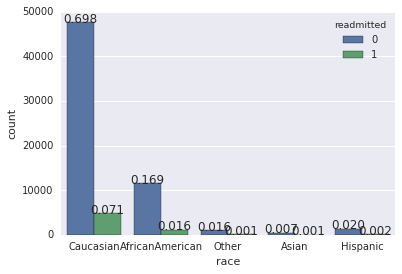

In [20]:
ax=sns.countplot(x='race',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 


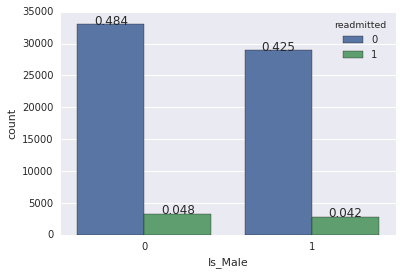

In [21]:
ax=sns.countplot(x='Is_Male',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 


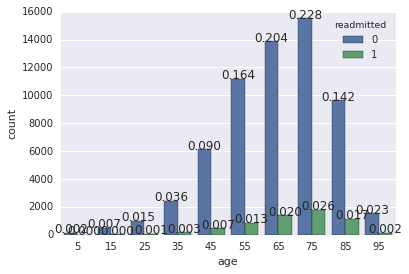

In [22]:
ax=sns.countplot(x='age',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

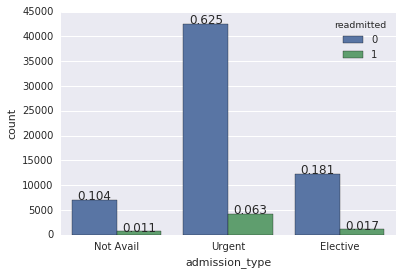

In [23]:
ax=sns.countplot(x='admission_type',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

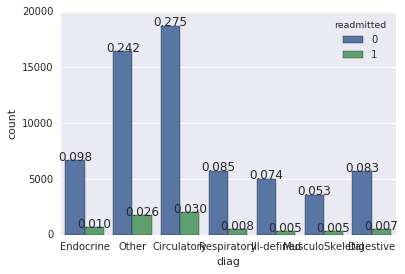

In [24]:
ax=sns.countplot(x='diag',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

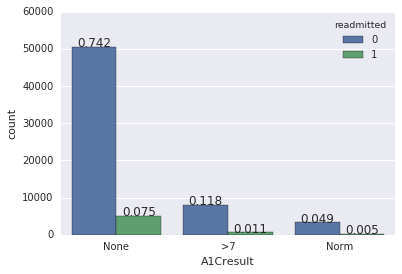

In [25]:
ax=sns.countplot(x='A1Cresult',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

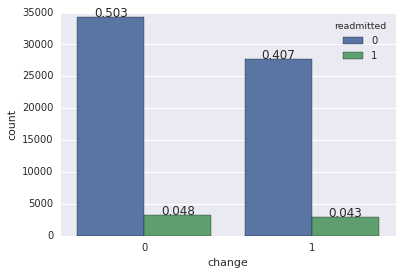

In [26]:
ax=sns.countplot(x='change',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

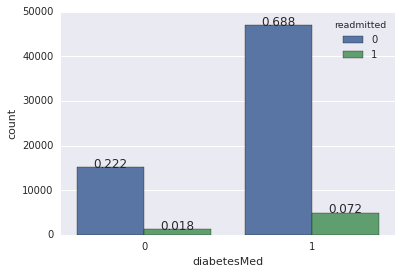

In [27]:
ax=sns.countplot(x='diabetesMed',hue='readmitted', data=df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/total),
            ha="center") 

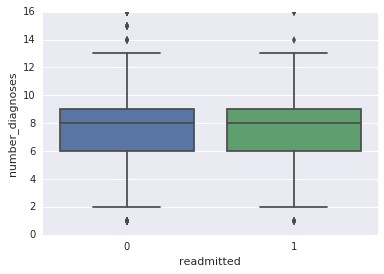

In [28]:
sns.boxplot(y=df['number_diagnoses'], x = df['readmitted'])

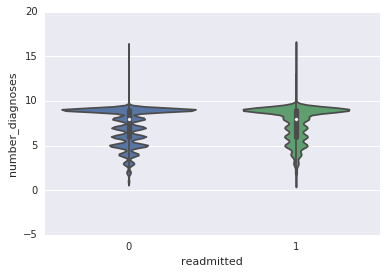

In [29]:
sns.violinplot(x=df["readmitted"], y=df["number_diagnoses"])

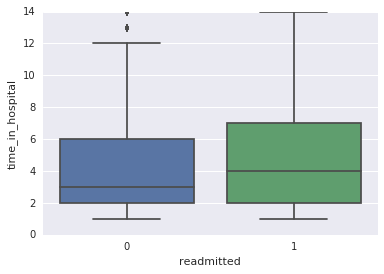

In [30]:
sns.boxplot(x=df["readmitted"], y=df["time_in_hospital"])

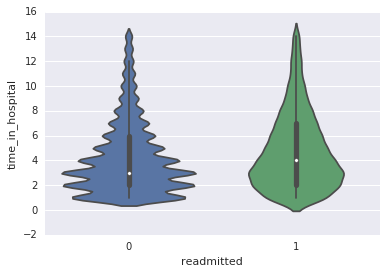

In [31]:
sns.violinplot(y=df["time_in_hospital"], x=df["readmitted"])

In [32]:
df['change']

0         0
1         1
2         0
3         1
4         1
5         0
6         1
7         0
8         1
9         1
10        0
11        1
12        1
13        0
14        0
15        1
16        1
17        0
18        0
22        0
23        0
24        1
25        0
26        1
27        0
28        1
29        1
30        1
31        1
32        0
         ..
101713    1
101714    0
101716    1
101717    0
101718    0
101719    1
101720    1
101721    1
101722    1
101723    0
101724    0
101725    1
101726    1
101729    0
101730    0
101731    1
101733    1
101737    1
101740    1
101745    1
101748    1
101749    1
101751    1
101752    1
101753    1
101754    1
101755    1
101756    0
101758    1
101765    0
Name: change, dtype: int64

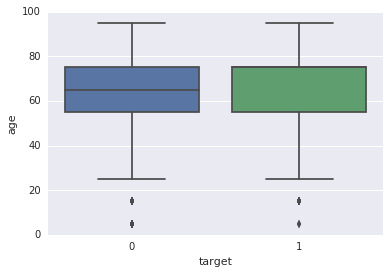

In [33]:
sns.boxplot(y=df['age'], x = df['target']);

In [34]:
df.describe()

,age,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted,target,Is_Male
count,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000,68158.000000
mean,65.440447,5.656108,4.274436,42.845301,1.426333,15.663605,0.283283,0.105857,0.179421,7.241028,0.449294,0.760175,0.090349,0.090349,0.467150
std,15.974940,4.177967,2.934460,19.921867,1.754592,8.276431,1.073460,0.517222,0.606595,1.995477,0.497426,0.426980,0.286683,0.286683,0.498923
min,5.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,65.000000,7.000000,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,75.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,95.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df['readmitted'].describe()

count    68158.000000
mean         0.090349
std          0.286683
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: readmitted, dtype: float64

In [36]:
df.dtypes

race                   object
age                     int64
admission_source_id     int64
time_in_hospital        int64
medical_specialty      object
num_lab_procedures      int64
num_procedures          int64
num_medications         int64
number_outpatient       int64
number_emergency        int64
number_inpatient        int64
number_diagnoses        int64
A1Cresult              object
change                  int64
diabetesMed             int64
readmitted              int64
target                  int64
Is_Male                 int64
admission_type         object
diag                   object
dtype: object

In [37]:
df["A1Cresult"].unique()

array(['None', '>7', 'Norm'], dtype=object)

In [38]:
df["change"].unique()

array([0, 1])

In [39]:
df["diag"].unique()

array(['Endocrine', 'Other', 'Circulatory', 'Respiratory', 'Ill-defined',
       'MusculoSkeletal', 'Digestive'], dtype=object)

In [40]:
df["admission_source_id"].unique()

array([ 1,  7,  2,  4,  5, 20,  6,  3, 17,  8,  9, 10, 22, 14, 11, 25, 13])

In [41]:
df["admission_type"].unique()

array(['Not Avail', 'Urgent', 'Elective'], dtype=object)

In [42]:
df["age"].unique()

array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

In [43]:
cleanup_nums = {"A1Cresult"     : {"None": 1, ">7": 2, "Norm": 3},
                "admission_type": {"Not Avail": 1, "Urgent": 2, "Elective": 3},
                "diag"          : {"Endocrine": 1, "Other": 2, "Circulatory":3, "Respiratory":4, "Ill-defined":5, "MusculoSkeletal":6, "Digestive":7 }}

df = pd.get_dummies( df, columns = ['A1Cresult','admission_type','diag'] )

In [44]:
#df.replace(cleanup_nums, inplace=True)
df.head()

,race,age,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,admission_type_Elective,admission_type_Not Avail,admission_type_Urgent,diag_Circulatory,diag_Digestive,diag_Endocrine,diag_Ill-defined,diag_MusculoSkeletal,diag_Other,diag_Respiratory
0,Caucasian,5,1,1,Pediatrics-Endocrinology,41,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,Caucasian,15,7,3,?,59,0,18,0,0,...,0,0,1,0,0,1,0,0,0,0
2,AfricanAmerican,25,7,2,?,11,5,13,2,0,...,0,0,1,0,0,0,0,0,1,0
3,Caucasian,35,7,2,?,44,1,16,0,0,...,0,0,1,0,0,0,0,0,1,0
4,Caucasian,45,7,1,?,51,0,8,0,0,...,0,0,1,0,0,0,0,0,1,0


In [45]:
xvars2 = df[[ 'age', 'time_in_hospital',
        'num_lab_procedures', 'num_procedures','number_outpatient','Is_Male',
       'num_medications',  'number_emergency',
       'number_inpatient', 'diag_Endocrine','diag_Other','diag_Circulatory','diag_Respiratory','diag_Ill-defined','diag_MusculoSkeletal','diag_Digestive', 
       'number_diagnoses', 'A1Cresult_None','A1Cresult_>7','A1Cresult_Norm','change', 'diabetesMed', 'admission_type_Not Avail','admission_type_Urgent','admission_type_Elective', 'readmitted']]
yvar = df['target']
#xvars = df[[ 'age', 'time_in_hospital','admission_source_id',
#        'num_lab_procedures', 'num_procedures','number_outpatient','Is_Male',
#       'num_medications',  'number_emergency',
#       'number_inpatient', 'diag', 
#       'number_diagnoses', 'A1Cresult', 'change', 'diabetesMed', 'admission_type']]
#

#df[[ 'age', 'time_in_hospital','admission_source_id',
#        'num_lab_procedures', 'num_procedures','number_outpatient','Is_Male',
#       'num_medications',  'number_emergency',
#       'number_diagnoses', 'A1Cresult_1','A1Cresult_2','A1Cresult_3','change', 'diabetesMed', 'admission_type_1','admission_type_2','admission_type_3', 'readmitted']]
#









In [46]:
#xvars.dtypes
yvar.dtypes

dtype('int64')

In [48]:
pd.to_numeric(xvars2, errors='ignore')

,age,time_in_hospital,num_lab_procedures,num_procedures,number_outpatient,Is_Male,num_medications,number_emergency,number_inpatient,diag_Endocrine,...,number_diagnoses,A1Cresult_None,A1Cresult_>7,A1Cresult_Norm,change,diabetesMed,admission_type_Not Avail,admission_type_Urgent,admission_type_Elective,readmitted
0,5,1,41,0,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,0
1,15,3,59,0,0,0,18,0,0,1,...,9,1,0,0,1,1,0,1,0,0
2,25,2,11,5,2,0,13,0,1,0,...,6,1,0,0,0,1,0,1,0,0
3,35,2,44,1,0,1,16,0,0,0,...,7,1,0,0,1,1,0,1,0,0
4,45,1,51,0,0,1,8,0,0,0,...,5,1,0,0,1,1,0,1,0,0
5,55,3,31,6,0,1,16,0,0,0,...,9,1,0,0,0,1,0,1,0,0
6,65,4,70,1,0,1,21,0,0,0,...,7,1,0,0,1,1,0,0,1,0
7,75,5,73,0,0,1,12,0,0,0,...,8,1,0,0,0,1,0,1,0,0
8,85,13,68,2,0,0,28,0,0,0,...,8,1,0,0,1,1,0,1,0,0
9,95,12,33,3,0,0,18,0,0,0,...,8,1,0,0,1,1,0,0,1,0


In [49]:
dXTrain, dXVald = train_test_split(xvars2, train_size=0.5, random_state=2) # technically this is mX and mY both in it.
dXVald,dXTest = train_test_split(xvars2,train_size=0.6,random_state=2)
dYTrain = dXTrain['readmitted']
dXTrain = dXTrain.drop('readmitted', axis=1)

dYVald  = dXVald['readmitted']
dXVald  = dXVald.drop('readmitted', axis=1)


dYTest  = dXTest['readmitted']
dXTest  = dXTest.drop('readmitted', axis=1)


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [50]:
treeobj = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
treefit= treeobj.fit(dXTrain, dYTrain)


In [51]:
treefit

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
#dot_data = tree.export_graphviz(treefit, out_file=None)
#graph = graphviz.Source(dot_data)
#graph

In [57]:
#logit = sm.Logit(yvar,xvars2 )
#result = logit.fit()
#result.summary()

In [58]:
print(accuracy_score (dYVald, treefit.predict(dXVald)))
print(accuracy_score (dYTest, treefit.predict(dXTest)))

0.970240133027
0.818661971831


In [59]:
sum(treefit.predict(dXVald))*1.0/len(dXVald)

0.092996527607962051

In [60]:
sum(dYVald)*1.0/len(dYVald)

0.088423729642490345

In [61]:
0.0022252653200958575/0.088423729642490345

0.02516592920353982

In [62]:
#onesindata = []
onescorrectlyidentified = []
missclassificationrate = []
treedepth = [3,4,5,6,7,8,9,10,11,12,13,14,15]
for i in treedepth:
    treeob=tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=i,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
    treefit = treeob.fit(dXVald, dYVald)
    onescorrectlyidentified.append(sum((treefit.predict(dXVald))*1.0/len(dXVald))/(sum(dYVald)*1.0/len(dYVald)))
    missclassificationrate.append(1-accuracy_score (dYVald, treefit.predict(dXVald)))
    
    
    
    

In [64]:
missclassificationrate

[0.088277008852154393,
 0.088179194991930387,
 0.088056927666650409,
 0.087690125690810361,
 0.087152149459578387,
 0.086125103927226498,
 0.084902430674426599,
 0.082946153469946715,
 0.081209957450970816,
 0.078299995109306963,
 0.074558614955739233,
 0.07015699124565955,
 0.064801682398395899]

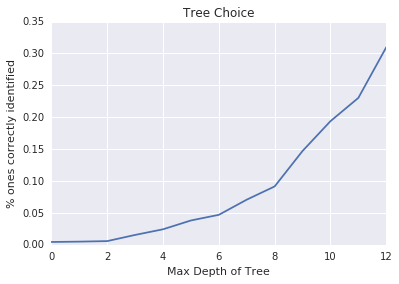

In [65]:
plt.plot(onescorrectlyidentified)

plt.xlabel('Max Depth of Tree')
plt.ylabel('% ones correctly identified')
plt.title('Tree Choice')

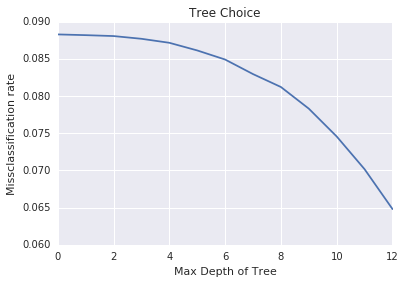

In [66]:
plt.plot(missclassificationrate)

plt.xlabel('Max Depth of Tree')
plt.ylabel('Missclassification rate')
plt.title('Tree Choice')